# Learn

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import pandas as pd
import matplotlib.pylab as plt

from astropy.io import fits
from astropy.coordinates import SkyCoord, match_coordinates_sky
import astropy.units as units

from uncertainties import ufloat
from collections import Counter

from functions import *

%matplotlib inline

MKDEBUG 2 functions.py


## Parameters

### Base name of matched catalogue
Name without file extension '.csv' of the matched catalogue containing magnitudes and spectra.

In [13]:
# Stephen's UNIONS+SDSS
#base_name = 'unions.ugriz'

# Stephen's UNIONS+DEEP3
base_name = 'w3.ugriz.spec_matched'

# Stephen's UNIONS MK-matched with SDSS
#base_name = 'unions.ugriz2'

# Shear Data Club catalogue from Xavier, W3+Deep23 (2021)
#base_name = 'CFIS_matched_alldeep_catalog_lephare_RIZGY'

### Input file columns

#### Photometric bands

In [4]:
bands = ['u', 'g', 'r', 'i', 'z']

#bands = ['MAG_AUTO_Z', 'MAG_AUTO_Y', 'MAG_AUTO_R', 'MAG_AUTO_I', 'MAG_AUTO_G,']

In [22]:
#### Spectroscopic redshift

col_zs = 'zspec'

#col_zs = 'Z_SPEC'

### Survey name
Specify a name for the survey. Result files will be stored in a corresponding subdirectory.

In [6]:
survey = 'W3_Deep23'

#survey = 'Xavier_W3_Deep23'

### Machine-learning parameters

In [147]:
# Action on missing data:
# None, BEST, drop, mode, mean, median, int/float value 
preprocessing = 'mode'

# number of samples for cross-validation, default=4
cv = 4

In [148]:
# Set paths

output_path = './'

# Input file path
path_to_csv = f'{base_name}.csv'

# Output paths
output_name = 'out'

temp_path = 'temp/'

In [149]:
# Clean up and generate subdirectories
GenFiles = GenerateFiles(survey, bands, temp_path, output_name, output_path)
GenFiles.clean_temp_directories()
for f in [False, True]:
    GenFiles.make_directories(output=f)

Successfully removed the directory temp/W3_Deep23/d2d/ 
Successfully removed the directory temp/W3_Deep23/matched/ 
Successfully removed the directory temp/W3_Deep23/unmatched/ 
Successfully removed the directory temp/W3_Deep23/vignet/ 
Successfully removed the directory temp/W3_Deep23/redshift/ 
Successfully removed the directory temp/W3_Deep23/spectral_surveys/ 
Successfully created the directory temp/W3_Deep23/vignet/u 
Successfully created the directory temp/W3_Deep23/vignet/g 
Successfully created the directory temp/W3_Deep23/vignet/r 
Successfully created the directory temp/W3_Deep23/vignet/i 
Successfully created the directory temp/W3_Deep23/vignet/z 
Successfully created the directory temp/W3_Deep23/vignet/array 


In [150]:
# Set up ML class
ML = LearningAlgorithms(
    survey=survey,
    bands=bands,
    path_to_csv=path_to_csv,
    output_name=output_name,
    output_path=output_path,
    cv=cv,
    preprocessing=preprocessing,
    n_jobs=2
)

In [151]:
df_matched = pd.read_csv(path_to_csv)

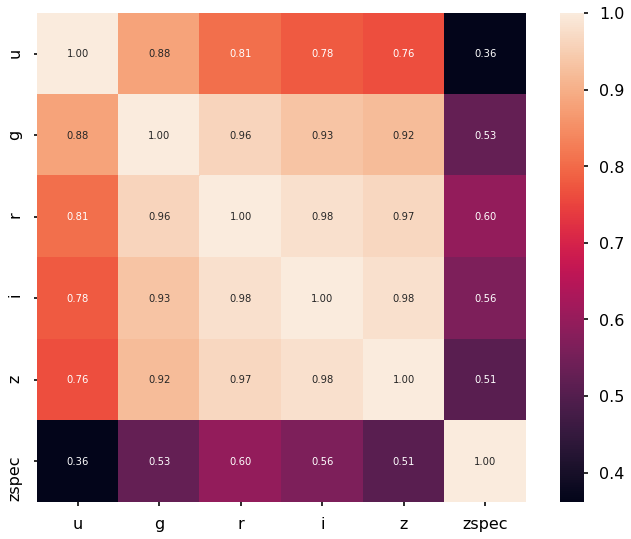

In [152]:
# Plot correlation matrix
ML.plot_corrmat(df_matched)

In [153]:
# Remove unwanted columns
cols_to_remove = []
for col in df_matched.columns:
    if (
        col not in bands
        and col != col_zs
    ):
        cols_to_remove.append(col)
df_matched.drop(columns=cols_to_remove, inplace=True)

In [154]:
n_cols = len(df_matched.columns)

# Move redshift column to the end if necessary
if not df_matched.columns[n_cols-1] == col_zs:
    zs = df_matched.pop(col_zs)
    df_matched.insert(n_cols-1, col_zs, zs)

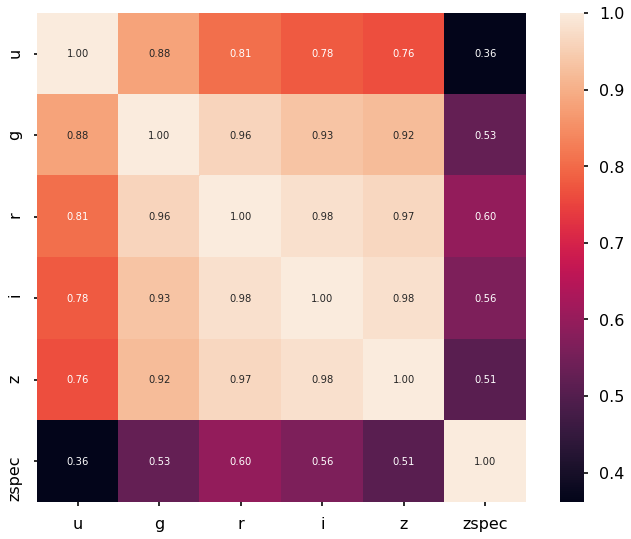

In [155]:
# Plot correlation matrix of preprocessed data
ML.plot_corrmat(df_matched)

In [156]:
# Set up ML algorithms

algs = {'RF': RandomForest}
weights = None
method = {}

for alg_name in algs:
    best_score = 1
    alg = algs[alg_name]
    method[alg_name] = alg(
        survey=survey,
        bands=bands,
        output_name=output_name,
        temp_path=temp_path,
        dataframe=df_matched,
        path_to_csv=None,
        validation_set=False,
        output_path=output_path,
        sample_weight=weights,
        cv=cv,
        preprocessing=preprocessing,
        n_jobs=1
    )

In [157]:
# Run ML algorithms
score = {}
predict = {}
y_pred_dict = {}
y_test_dict = {}

for alg_name in algs:

    # Get score from cross-validation
    score[alg_name] = method[alg_name].score(df_matched)

    # Fit model
    regressor, y_pred, y_test = method[alg_name].model()

    # Get predicted model values
    y_pred_dict[alg_name] = y_pred

    # Get ground truth for test
    y_test_dict[alg_name] = y_test
    
    # Get function to create prediction on any input
    predict[alg_name] = regressor.predict

100%|██████████| 4/4 [00:01<00:00,  2.61it/s]


In [158]:
# Print sigma and eta with error bars, as computed from cross-validation
for alg_name in algs:
    sigma = ufloat(score[alg_name][0], score[alg_name][1])
    eta = ufloat(score[alg_name][2], score[alg_name][3])
    print(
        f'{alg_name}: sigma={sigma:.3gP}, '
        + f'eta={eta:.3gP}',
        end='\r'
    )

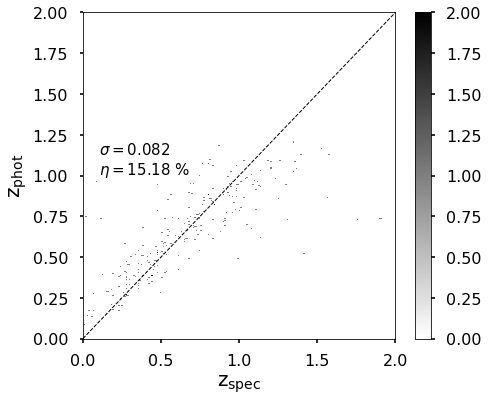

In [159]:
# Plot
lim = 2
for alg_name in algs:
    method[alg_name].plot_zphot_zspec(y_pred_dict[alg_name], y_test_dict[alg_name], alg_name, lim, nbins=200)

0.07916275464749005 0.13229571984435798


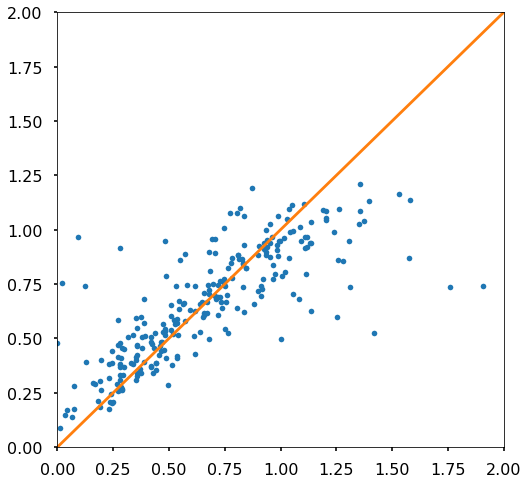

In [160]:
# Test of the predict function

plt.figure(figsize=(8, 8))
yphot = predict['RF'](method['RF'].X_test)
yspec = np.array(method['RF'].y_test)
plt.plot(yspec, yphot, '.')
plt.plot([0, 2], [0, 2], '-')
plt.xlim(0, 2)
_ = plt.ylim(0, 2)

sigma, eta = method['RF'].sigma_eta_score(yphot, yspec)
print(sigma, eta)

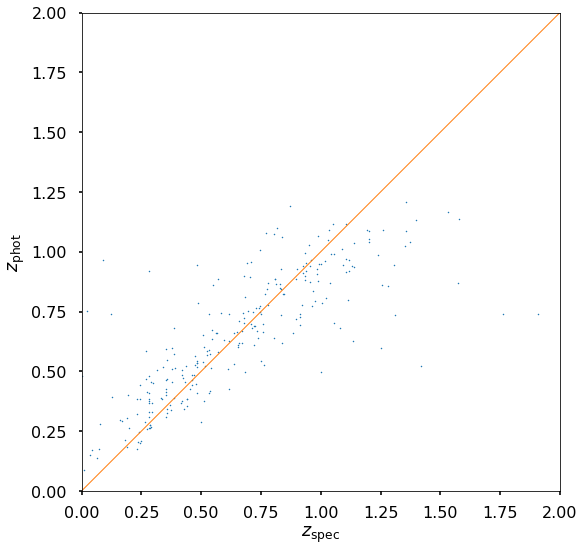

In [161]:
fig, (ax) = plt.subplots(1, 1)

ax.plot(y_test_dict['RF'], y_pred_dict['RF'], '.', markersize=3)
ax.plot([0, lim], [0, lim], '-', linewidth=1)
ax.set_ylim(0, lim)
ax.set_xlim(0, lim)
ax.set_xlabel(r'$z_{\rm spec}$')
ax.set_ylabel(r'$z_{\rm phot}$')
ax.set_aspect('equal')
_ = plt.savefig(f'{output_path}/output/{survey}/{output_name}/figures/out_RF_zphot_zspec_2.pdf')

# Apply

## Open SP catalogue

In [163]:
base_name_ph = 'cfis_800d2_SP_v1.0'

In [164]:
hdu = fits.open(f'{base_name_ph}.fits', memmap=False)

In [165]:
data = hdu[1].data

In [166]:
# Print column names
print(data.dtype.names)

('ra', 'dec', 'g1', 'g2', 'w', 'mag', 'snr', 'g1_uncal', 'g2_uncal', 'CFIS_ID', 'RA', 'Dec', 'distance', 'CFIS_ID_mb', 'CFIS_U_MAG_AUTO', 'CFIS_U_MAGERR_AUTO', 'HSC_G_MAG_AUTO', 'HSC_G_MAGERR_AUTO', 'CFIS_R_MAG_AUTO', 'CFIS_R_MAGERR_AUTO', 'PS_i_stk_kron', 'PS_i_stk_kron_err', 'PS_z_stk_kron', 'PS_z_stk_kron_err', 'CFIS_R_StarGal')


## Create data frame band column names defined above

In [167]:
# Column names corresponding to the above-defined bands
cols = ['CFIS_U_MAG_AUTO', 'HSC_G_MAG_AUTO', 'CFIS_R_MAG_AUTO', 'PS_i_stk_kron', 'PS_z_stk_kron']

In [175]:
data_for_df = {}
for b, c in zip(bands, cols):
    print(b, c)
    data_for_df[b] = data[c].tolist()

u CFIS_U_MAG_AUTO
g HSC_G_MAG_AUTO
r CFIS_R_MAG_AUTO
i PS_i_stk_kron
z PS_z_stk_kron


In [177]:
df = pd.DataFrame(data=data_for_df)

## Deal with missing data

In [179]:
# Replace invalid magnitudes with nan
df = df.replace([-99, -999], np.nan)

In [181]:
def missing_data(dataset):
    all_data_na = (dataset.isnull().sum() / len(dataset)) * 100
    all_data_na = all_data_na.drop(
        all_data_na[all_data_na == 0].index
    ).sort_values(ascending=False)[:30]
    missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
    
    return missing_data 

In [182]:
missing = missing_data(df)

In [185]:
# Replace missing data with mode (see preprocessing above)
for i in missing.index:
    df[i] = df[i].fillna(df[i].mode()[0])

In [187]:
yphot = predict['RF'](df)

0.8541392424478479 0.6656307392996108


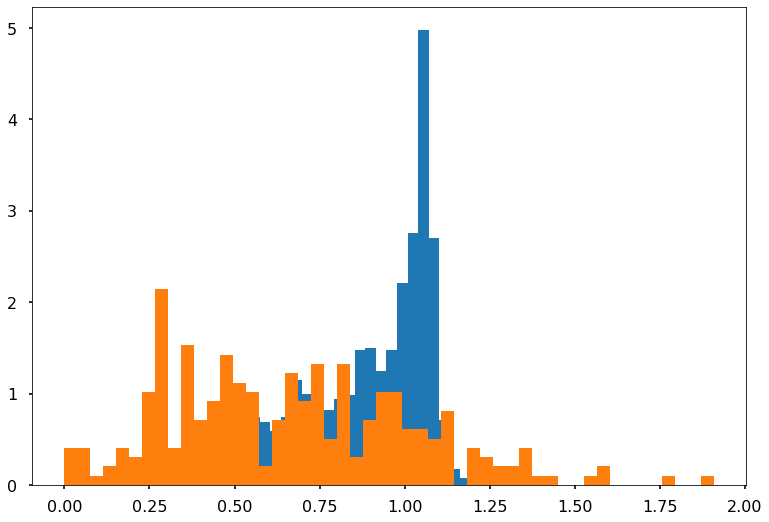

In [195]:
_ = plt.hist(yphot, bins=50, density=True)
_ = plt.hist(yspec, bins=50, density=True)
print(np.mean(yphot), np.mean(yspec))

In [208]:
col_names_out = ['ra', 'dec', 'g1', 'g2', 'w', 'mag', 'snr', 'CFIS_ID',
                 'CFIS_U_MAG_AUTO', 'CFIS_U_MAGERR_AUTO',
                 'HSC_G_MAG_AUTO', 'HSC_G_MAGERR_AUTO',
                 'CFIS_R_MAG_AUTO', 'CFIS_R_MAGERR_AUTO',
                 'PS_i_stk_kron', 'PS_i_stk_kron_err',
                 'PS_z_stk_kron', 'PS_z_stk_kron_err']

In [246]:
cols_orig = []
for col_input in data.columns:
    if col_input.name in col_names_out:
        cols_orig.append(col_input)
cols_orig = fits.ColDefs(cols_orig)

In [247]:
col_new = fits.ColDefs(
    [
        fits.Column(name='z_phot', format='D', array=yphot)
    ]
)

In [251]:
hdu_out = fits.BinTableHDU.from_columns(cols_orig + col_new)

In [252]:
out_name = f'{base_name_ph}_zp_{survey}_v0.1.fits'
hdu_out.writeto(out_name)